In [41]:
# Use package versions builtin to this repository.
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

# Load Flux and PlotlyJS for sweet interactive graphics
using Flux, Images, Metalhead, Random

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — /Users/sabae/.julia/registries/General — failed to fetch from repo
└ @ Pkg.API /Users/sabae/tmp/julia-build/julia-release-1.0/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:144


In [2]:
v = Metalhead.VGG19()
for idx in 1:length(v.layers.layers)
    @show v.layers[idx]
end

v.layers[idx] = Conv((3, 3), 3=>64, NNlib.relu)
v.layers[idx] = Conv((3, 3), 64=>64, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##44#50"))()
v.layers[idx] = Conv((3, 3), 64=>128, NNlib.relu)
v.layers[idx] = Conv((3, 3), 128=>128, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##45#51"))()
v.layers[idx] = Conv((3, 3), 128=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##46#52"))()
v.layers[idx] = Conv((3, 3), 256=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##47#53"))()
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx]

In [3]:
car = load("images/car.png")
dog = load("images/dog.png")
sky = load("images/sky.png");

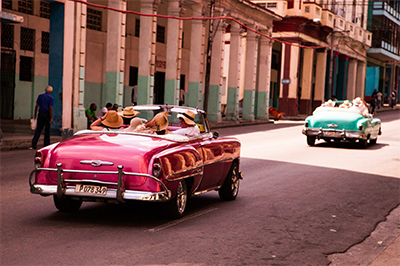

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│racer                 │ █████████      60.2% │
│sports car            │ █████▉         39.8% │
│car wheel             │                 0.0% │
│cab                   │                 0.0% │
│go-kart               │                 0.0% │
└─────────────────────────────────────────────┘


In [4]:
display(car)
display(predict(v, car))

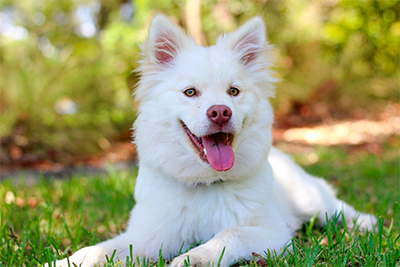

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│Samoyed               │ ██████████████▊98.8% │
│Eskimo dog            │                 0.5% │
│tennis ball           │                 0.2% │
│Pomeranian            │                 0.2% │
│Border collie         │                 0.1% │
└─────────────────────────────────────────────┘


In [5]:
display(dog)
display(predict(v, dog))

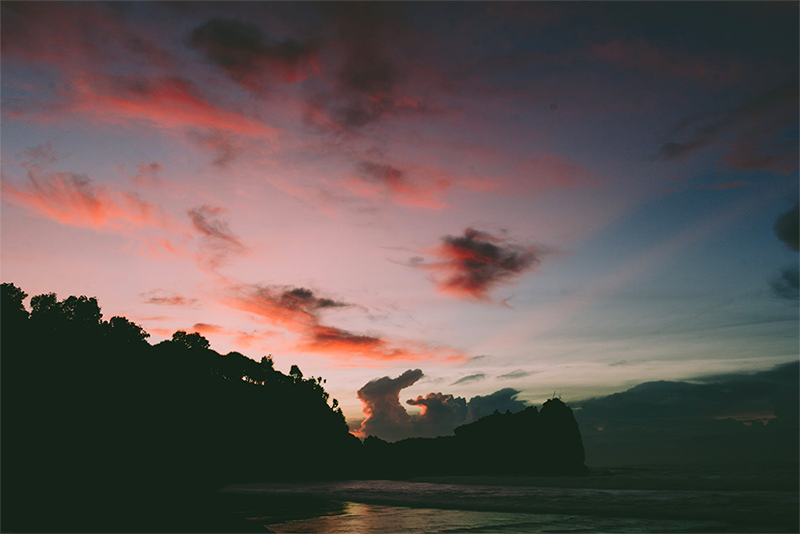

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│seashore              │ █████████████▏ 88.0% │
│lakeside              │ ▋               4.8% │
│castle                │ ▍               2.6% │
│church                │                 0.8% │
│beacon                │                 0.7% │
└─────────────────────────────────────────────┘


In [6]:
display(sky)
display(predict(v, sky))

In [68]:
# HD-NHD; we'll train up two dense layers on the end of the convolutional blocks
hotdog_model = Chain(
    v.layers[1:end-2]...,
    Dense(4096, 2),
    softmax,
);
opt = Flux.Optimise.ADAM(params(hotdog_model), 1e-2)

training_filenames = shuffle(vcat(
    [joinpath("hotdog_train/hot_dog", f) for f in readdir("hotdog_train/hot_dog")],
    [joinpath("hotdog_train/not_hot_dog", f) for f in readdir("hotdog_train/not_hot_dog")],
))

498-element Array{String,1}:
 "hotdog_train/hot_dog/1040579.jpg"   
 "hotdog_train/not_hot_dog/779193.jpg"
 "hotdog_train/hot_dog/1268739.jpg"   
 "hotdog_train/not_hot_dog/1164.jpg"  
 "hotdog_train/hot_dog/1107015.jpg"   
 "hotdog_train/hot_dog/1018245.jpg"   
 "hotdog_train/not_hot_dog/123902.jpg"
 "hotdog_train/not_hot_dog/174977.jpg"
 "hotdog_train/not_hot_dog/1167.jpg"  
 "hotdog_train/hot_dog/979767.jpg"    
 "hotdog_train/hot_dog/1186993.jpg"   
 "hotdog_train/not_hot_dog/824157.jpg"
 "hotdog_train/hot_dog/127117.jpg"    
 ⋮                                    
 "hotdog_train/not_hot_dog/146029.jpg"
 "hotdog_train/hot_dog/3543293.jpg"   
 "hotdog_train/not_hot_dog/5762.jpg"  
 "hotdog_train/not_hot_dog/106608.jpg"
 "hotdog_train/hot_dog/974520.jpg"    
 "hotdog_train/not_hot_dog/244006.jpg"
 "hotdog_train/not_hot_dog/89197.jpg" 
 "hotdog_train/hot_dog/3782895.jpg"   
 "hotdog_train/not_hot_dog/319830.jpg"
 "hotdog_train/hot_dog/1086675.jpg"   
 "hotdog_train/not_hot_dog/204169.j

In [69]:
# Preprocess all data beforehand
training_set = Tuple[]
for idx in 1:64 #length(training_filenames)
    if idx%10 == 1
        println("[$(idx)/$(length(training_filenames))]")
    end
    filename = training_filenames[idx]
    push!(training_set, (filename, Metalhead.preprocess(filename)))
end

[1/498]
[11/498]
[21/498]
[31/498]
[41/498]
[51/498]
[61/498]


In [74]:
# Run training loop on test images
function train(model, opt, training_set; batch_size = 8)
    # Shuffle the training set order
    training_set = shuffle(training_set)
    
    for batch_idx in 1:batch_size:length(training_set)
        println("batch $batch_idx")
        batch = training_set[batch_idx:batch_idx+batch_size-1]
        filenames = [d[1] for d in batch]
        data = cat([d[2] for d in batch]...; dims=4)

        # Push the batch of images through the model, getting y_hat, our prediction values
        y_hat = softmax(model(data))
        
        # If the filename has `not_hot_dog` within it, we know it's not a hot dog.
        # Use this to build our known `y` vector.
        y = Int64.(occursin.("not_hot_dog", filenames))
        y = Float64.(collect(Flux.onehotbatch(y, 0:1)))
        
        # Calculate loss and backpropagate
        loss = Flux.mse(y_hat .+ eps(Float64), y)
        Flux.back!(loss)
        
        # Take an optimizer step
        opt()
    end
end

train(hotdog_model, opt, training_set)

batch 1
batch 9
batch 17
batch 25
batch 33
batch 41
batch 49
batch 57


In [67]:
occursin.(Ref("asd"), ["aeaf", "aeghs", "Aerhaeasd", "rhsasdaega"])

4-element BitArray{1}:
 false
 false
  true
  true

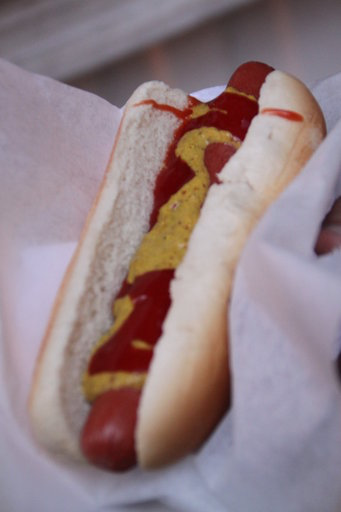

"Hot Dog!"

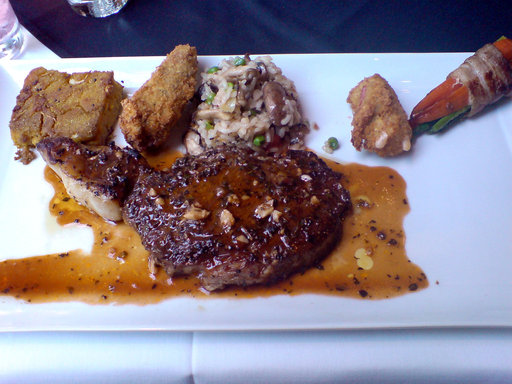

"Not Hot Dog!"

In [79]:
function test_img(filepath)
    img = load(filepath)
    display(img)
    prediction = hotdog_model(Metalhead.preprocess(img))
    if prediction[1] > prediction[2]
        display("Hot Dog!")
    else
        display("Not Hot Dog!")
    end
end

test_img("hotdog_test/hot_dog/139177.jpg")
test_img("hotdog_test/not_hot_dog/7056.jpg")